<a href="https://colab.research.google.com/github/reetam-ganguli/dlprojectfinalovcanc/blob/main/TCGA_DL_final_project%2C_CNN_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
#@title 
# General Use
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

 

# Training
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, auc, precision_recall_curve


#DL imports
 
import keras
from keras import backend as K
from keras.models import Sequential

import tensorflow as tf
 
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, AveragePooling1D, AveragePooling2D, Conv1D, Flatten, Dropout, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy

!pip install optuna
import optuna

In [4]:
# read and display shape of data
# path = 'cnv_methyl_mrna_clinical.csv'
import os
path = 'vanilla_encoded_cnv_methyl_mrna_biomed_clinical_85_features.csv'
!ls
df= pd.read_csv(path)
 
df.shape
df.head(10)

sample_data  vanilla_encoded_cnv_methyl_mrna_biomed_clinical_85_features.csv


(450, 213)

,Unnamed: 0,concentration,normal_tumor_genotype_match,pcr_amplification_successful,intermediate_dimension,is_ffpe,longest_dimension,sample_type_id,shortest_dimension,percent_necrosis,percent_normal_cells,percent_stromal_cells,percent_tumor_cells,percent_tumor_nuclei,section_location,pharmaceutical_therapy_type,pharmaceutical_tx_started_days_to_x,pharmaceutical_tx_ongoing_indicator,pharmaceutical_tx_ended_days_to,pharma_adjuvant_cycles_count,radiation_treatment_adjuvant_x,pharmaceutical_tx_adjuvant_x,treatment_outcome_first_course_x,vital_status_x,last_contact_days_to_x,birth_days_to,ethnicity,history_neoadjuvant_treatment_y,vital_status_y,last_contact_days_to_y,tumor_grade,age_at_initial_pathologic_diagnosis,days_to_initial_pathologic_diagnosis,DNA,GenomePlex (Rubicon) Amplified DNA,RNA,Repli-G (Qiagen) DNA,Total RNA,PicoGreen,UV Spec,Blood Derived Normal,Primary Tumor,Recurrent Tumor,Solid Tissue Normal,IP,IP|IV,IV,Other (specify below),PO,ADJUVANT,"OTHER, SPECIFY IN NOTES",PALLIATIVE,PROGRESSION,AMERICAN INDIAN OR ALASKA NATIVE,ASIAN,BLACK OR AFRICAN AMERICAN,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,WHITE,Cytology (e.g. Peritoneal or pleural fluid),Excisional Biopsy,Fine needle aspiration biopsy,Incisional Biopsy,"Other method, specify:",Tumor resection,Bilateral,Left,Right,Omentum,Ovary,Peritoneum ovary,1-10 mm,11-20 mm,>20 mm,No Macroscopic disease,Stage IA,Stage IB,Stage IC,Stage IIA,Stage IIB,Stage IIC,Stage IIIA,Stage IIIB,Stage IIIC,Stage IV,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,...,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,RECURRENCE
0,TCGA-10-0926-01,0.15,1,1.000000,0.8,0,1.0,1.0,0.6,0,2.0,0.0,98.0,99,0,1.0,290.0,0.000000,729.0,13.000000,1.0,1.0,1,0,788.0,-23307.0,0.001801,0,0,788.0,3.0,63,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.000000,0.073649,1.000000,3.896559e-01,0.000340,3.561266e-09,0.102453,1.000000,0.999965,1.0,0.998283,0.991972,1.0,0.944839,1.0,0.297801,...,0.999998,0.610483,1.0,0.906578,0.986108,1.0,1.000000,1.0,0.999999,0.027495,0.478273,0.999999,0.999416,1.000000,0.974016,1.000000,1.000000,3.463679e-10,0.999994,0.002799,0.999997,0.999991,1.000000,1.000000,1.000000,0.998486,7.690646e-15,1.000000,0.963218,4.069718e-08,0.027125,1.092884e-10,0.688925,2.146192e-11,1.000000,0.881116,0.116067,0.013808,1.0,9.363929e-03,1.0,0.515923,4.278337e-10,0.993899,0.999991,1.0,0.998692,0.999996,0.987675,0.930790,0.999993,0.691585,1.000000,5.672499e-08,0.856181,1.000000,0.033011,3.491291e-10,1.000000,0.000071,3.874622e-08,5.614363e-08,2.961257e-06,9.580406e-11,0.999998,5.942318e-07,0.999880,1.000000,0.995176,7.301903e-10,0.998277,0.981147,1.0,0.999996,0.943405,3.390123e-07,0.000014,1.762634e-10,1.510083e-08,0.999980,5.052402e-11,0.997085,0.999998,7.232052e-07,0.043652,1.0,1.0,1.469782e-06,0.860844,8.224647e-08,0.598811,0.999999,1.0,0.999999,0.984497,1.000000,1.000000,9.303836e-11,0.999999,1
1,TCGA-10-0927-01,0.14,1,1.000000,0.7,0,1.1,1.0,0.6,0,5.0,5.0,90.0,95,1,1.0,1601.0,-0.057624,1686.0,10.000000,0.0,1.0,1,0,2478.0,-23982.0,1.000000,0,0,2478.0,2.0,65,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.999999,0.030719,1.000000,1.118270e-01,0.000316,9.160425e-09,0.319987,1.000000,0.999997,1.0,0.998433,0.993931,1.0,0.900598,1.0,0.864601,...,0.999999,0.791365,1.0,0.503002,0.984892,1.0,1.000000,1.0,1.000000,0.070237,0.653069,0.999999,0.999686,0.999995,0.589774,1.000000,1.000000,3.664771e-10,0.999995,0.006132,0.999999,0.999995,1.000000,1.000000,1.000000,0.997478,1.035691e-14,0.999999,0.991500,3.050846e-08,0.016541,6.893233e-11,0.817267,1.201688e-11,1.000000,0.892347,0.153515,0.045990,1.0,9.515822e-03,1.0,0.466771,1.946249e-10,0.98663

In [29]:
df.RECURRENCE

0      1
1      0
2      0
3      1
4      0
      ..
445    0
446    0
447    0
448    0
449    0
Name: RECURRENCE, Length: 450, dtype: int64

In [7]:
df.RECURRENCE.value_counts()

0    391
1     59
Name: RECURRENCE, dtype: int64

In [59]:
y = df['RECURRENCE']
X = df.drop(columns=["treatment_outcome_first_course_x", 'RECURRENCE', "Unnamed: 0", 'ADJUVANT', 	"pharmaceutical_tx_started_days_to_x",	"pharmaceutical_tx_ongoing_indicator",	"pharmaceutical_tx_ended_days_to"], inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)
X.shape
X_train.shape
X_test.shape
y_train.value_counts()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))


(450, 206)

(337, 206)

(113, 206)

0    293
1     44
Name: RECURRENCE, dtype: int64

In [114]:
from keras import regularizers
from keras.engine.input_layer import Input
# CNN Model

# dropout_input = 0.1
# dropout_output = 0.1
# dense_hid = 256
# channels_in = 64
# channels_hid = 128

#========loss: 1.4545 - auc_4: 0.5133  accuracy: 0.8673========
# TESTING ^^
##################################################################
# dropout_input = 0.1
# dropout_output = 0.1
# dense_hid = 1024
# channels_in = 64
# channels_hid = 32

#==========oss: 1.0374 - AUC: 0.6323 accuracy: 0.8673=====
# TESTING ^^
##################################################################
dropout_input = 0.3
dropout_output = 0.3
dense_hid = 1024
channels_in = 64
channels_hid = 32

### 



modelCNN = Sequential(
    [   
        keras.Input(shape=(206), name='Inputs'),
        BatchNormalization(name='batchnorm1'),
        Dropout(dropout_input, name='dropout_inputs'),
        Dense(dense_hid, activation='relu', name='dense_inputs'),

        Reshape((-1,1, channels_in), name='reshape'),

        BatchNormalization(name='batchnorm2'),
        Conv1D(channels_hid, 3, strides=1,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(), name='firstConv'),

        AveragePooling2D(pool_size=2, strides=2, padding='same', data_format='channels_last', name='avgPool1'),

        BatchNormalization(name='batchnorm3'),
        Conv1D(channels_hid, 3, strides=1, padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(), name='secondConv'),

        BatchNormalization(name='batchnorm4'),
        Conv1D(channels_hid, 5, strides=1,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(),name='thirdConv'),
     
        BatchNormalization(name='batchnorm5'),
        Conv1D(channels_hid, 5, strides=1,padding='same', activation='relu',kernel_regularizer=keras.regularizers.l2(),name='fourthConv'),

        AveragePooling2D(2, strides=2, padding='same',name='avgPool2'),
        Flatten(),

        BatchNormalization(name='batchnorm6'),
        Dropout(dropout_output),
        Dense(1, activation='sigmoid')
    ],
    name='SoftOrderingCNN1D'
)

modelCNN.summary()


Model: "SoftOrderingCNN1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batchnorm1 (BatchNormalizat  (None, 206)              824       
 ion)                                                            
                                                                 
 dropout_inputs (Dropout)    (None, 206)               0         
                                                                 
 dense_inputs (Dense)        (None, 1024)              211968    
                                                                 
 reshape (Reshape)           (None, 16, 1, 64)         0         
                                                                 
 batchnorm2 (BatchNormalizat  (None, 16, 1, 64)        256       
 ion)                                                            
                                                                 
 firstConv (Conv1D)          (None, 16, 1, 32)   

In [115]:
from sklearn.metrics import roc_curve,roc_auc_score
### HPs ####
BATCH_SIZE = 100
LR = 0.001
NUM_EPOCHS = 10


modelCNN.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),  
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(name="AUC"), 'accuracy']
        )

modelCNN.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

# modelCNN.predict_pr
print("\n\nEVALUATE")
results = modelCNN.evaluate(X_test, y_test,batch_size=BATCH_SIZE)
print("test loss, test acc:", results)


        

Epoch 1/10
4/4 [==============================] - 2s 14ms/step - loss: 2.2753 - AUC: 0.4508 - accuracy: 0.4629
Epoch 2/10
4/4 [==============================] - 0s 13ms/step - loss: 2.1023 - AUC: 0.5841 - accuracy: 0.5282
Epoch 3/10
4/4 [==============================] - 0s 14ms/step - loss: 1.9478 - AUC: 0.7015 - accuracy: 0.6142
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: 1.7589 - AUC: 0.7817 - accuracy: 0.6588
Epoch 5/10
4/4 [==============================] - 0s 13ms/step - loss: 1.6826 - AUC: 0.7619 - accuracy: 0.6588
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 1.5496 - AUC: 0.8270 - accuracy: 0.7033
Epoch 7/10
4/4 [==============================] - 0s 14ms/step - loss: 1.4983 - AUC: 0.8480 - accuracy: 0.7240
Epoch 8/10
4/4 [==============================] - 0s 15ms/step - loss: 1.4447 - AUC: 0.8941 - accuracy: 0.7003
Epoch 9/10
4/4 [==============================] - 0s 15ms/step - loss: 1.3568 - AUC: 0.8985 - accuracy: 0.7389
E



EVALUATE
2/2 [==============================] - 0s 5ms/step - loss: 1.3009 - AUC: 0.5303 - accuracy: 0.8673
test loss, test acc: [1.3008568286895752, 0.5302721261978149, 0.8672566413879395]


In [ ]:


modelCNN

fpr , tpr , thresholds = roc_curve ( y_val_cat , y_val_cat_prob)

.

.

.

.

.

.

.

.

.

.

.

.


.

.
.
.















.

In [ ]:
#machine learning baseline  XGB recurrence NO adjuvant to test, xgb has .65 auc roc and 87% accuracy


XGBClassifier()

0.8584070796460177

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


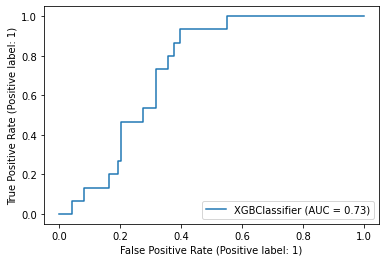

Thresholds: 
[1.5224338  0.52243376 0.4370894  0.32851547 0.22622798 0.21781535
 0.16833393 0.16079338 0.13245319 0.12123023 0.11233435 0.08831338
 0.06946444 0.06933112 0.05854366 0.05489765 0.05219491 0.04490361
 0.04450509 0.04273833 0.03891328 0.03630765 0.02737606 0.02652743
 0.00212201]


In [ ]:
#achine learning for recurrence  XGB recurrence
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_prob = model.predict_proba(X_test)
model.score(X_test, y_test)
pred_prob = [point[1] for point in pred_prob]

from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
plot_roc_curve(model, X_test, y_test)  
plt.show()

print("Thresholds: ") 
print(thresholds)

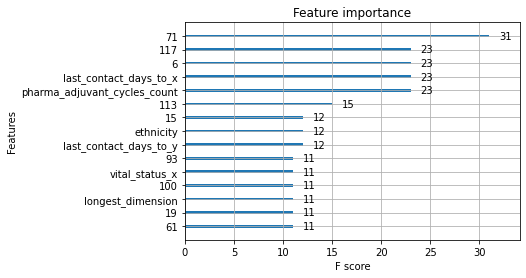

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model, max_num_features=15)
pyplot.show()

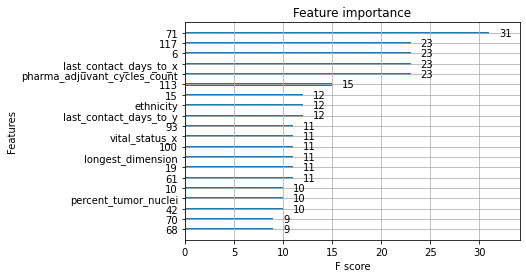

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model, max_num_features=20)
pyplot.show()

===== start XGB =====


XGBClassifier()

===== start RandomForest =====


RandomForestClassifier()

===== start LogisticRegression =====


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

===== start plotting results =====


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

Text(0.5, 0.98, 'ROC Curve Comparison for Ground Truth Data')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


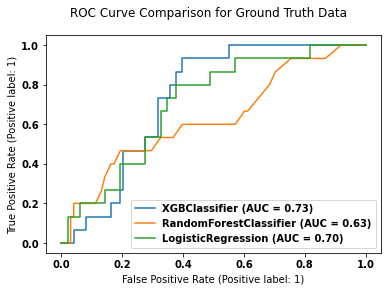

In [ ]:
print("===== start XGB =====")
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("===== start RandomForest =====")
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
print("===== start LogisticRegression =====")
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


print("===== start plotting results =====")

font = {"family": "normal", "weight": "bold", "size": 10}

import matplotlib
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
matplotlib.rc("font", **font)

xgb_disp = plot_roc_curve(xgb, X_test, y_test)
forest_disp = plot_roc_curve(forest, X_test, y_test, ax=xgb_disp.ax_)
logreg_disp = plot_roc_curve(logreg, X_test, y_test, ax=xgb_disp.ax_)
logreg_disp.figure_.suptitle("ROC Curve Comparison for Ground Truth Data")

In [ ]:

# LSTM and CNN for sequence classification 
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

top_words = 206


# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=top_words))
model.add(Conv1D(filters=32, kernel_size=206, activation='relu'))

model.add(LSTM(206))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=20, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: ignored

In [ ]:
X_test.shape

(113, 206)

In [ ]:
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(206, input_dim=206, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
# estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='glorot_uniform'):
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=206, kernel_initializer=init, activation='relu'))
	# model.add(Dense(8, kernel_initializer=init, activation='relu'))
	model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
	return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# y = df['treatment_outcome_first_course_x']
# X = df.drop(columns=["treatment_outcome_first_course_x", "Unnamed: 0"], inplace=False)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [20, 50]
batches = [32, 64, 128]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.871111 using {'batch_size': 32, 'epochs': 20, 'init': 'uniform', 'optimizer': 'adam'}
0.682222 (0.282982) with: {'batch_size': 32, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.768889 (0.205529) with: {'batch_size': 32, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.691111 (0.315712) with: {'batch_size': 32, 'epochs': 20, 'init': 'normal', 'optimizer': 'rmsprop'}
0.844444 (0.078567) with: {'batch_size': 32, 'epochs': 20, 'init': 'normal', 'optimizer': 'adam'}
0.868889 (0.062222) with: {'batch_size': 32, 'epochs': 20, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.871111 (0.045866) with: {'batch_size': 32, 'epochs': 20, 'init': 'uniform', 'optimizer': 'adam'}
0.862222 (0.066146) with: {'batch_size': 32, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.693333 (0.214488) with: {'batch_size': 32, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.848889 (0.053794) with: {'batch_size': 32, 'epochs': 50, 'init': 'normal',

In [ ]:
# grid_result.best_score_
#auroc .67 last tine
y_pred_proba = grid_result.best_estimator_.predict_proba(X_test)[::,1]

print(roc_auc_score(y_test, y_pred_proba))

0.6333333333333334


In [ ]:
# NOW TRYING with 3 layers
def create_model(optimizer='adam', init='glorot_uniform'):
	# create model
	model = Sequential()
	model.add(Dense(128, input_dim=206, kernel_initializer=init, activation='relu'))
	model.add(Dense(16, kernel_initializer=init, activation='relu'))
	model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
	return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# y = df['treatment_outcome_first_course_x']
# X = df.drop(columns=["treatment_outcome_first_course_x", "Unnamed: 0"], inplace=False)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [20, 50]
batches = [8, 32, 64, 128]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, y) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.873333 using {'batch_size': 32, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
0.835556 (0.088722) with: {'batch_size': 8, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.715556 (0.164595) with: {'batch_size': 8, 'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.868889 (0.062222) with: {'batch_size': 8, 'epochs': 20, 'init': 'normal', 'optimizer': 'rmsprop'}
0.866667 (0.065922) with: {'batch_size': 8, 'epochs': 20, 'init': 'normal', 'optimizer': 'adam'}
0.868889 (0.062222) with: {'batch_size': 8, 'epochs': 20, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.868889 (0.062222) with: {'batch_size': 8, 'epochs': 20, 'init': 'uniform', 'optimizer': 'adam'}
0.748889 (0.217574) with: {'batch_size': 8, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.751111 (0.227775) with: {'batch_size': 8, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.868889 (0.062222) with: {'batch_size': 8, 'epochs': 50, 'init': 'normal', 'optimize

In [ ]:
# grid_result.best_score_
#auroc .67 last tine
y_pred_proba = grid_result.best_estimator_.predict_proba(X_test)[::,1]

print(roc_auc_score(y_test, y_pred_proba))

0.6931972789115647
